# Basicness vs Advanced Ranking

Ranking su basicness dei synset di WordNet. Si richiede di creare un mapping tra i synset di WordNet ed un basicness score (ad es. [0, 1]), utilizzando dati, risorse, features e approcci che credete opportuni alla risoluzione del task.

In [437]:
import json
import os
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Estrazione ed elaborazione dei dati

Ogni file ha informazioni relatveal tipo di concetto (synset) "base" o "avanzato", il tempo trascorso per affrontarlo, se l'annotatore ha trovato o meno difficile l'annotazione. Sono anche presenti frasi e definizioni. Non le userò ma attingerò a Wordnet.

Ho estratto queste informazioni e le ho organizzate in un formato più gestibile, su un DataFrame pandas.

In seguito, ho aggregato i dati per ciascun "synset", calcolando la somma e la media di alcune proprietà (come il tempo trascorso) e ho contato le occorrenze dei "Basic"concept e dei "isNotHard". Ho normalizzato poi ciascun valore per limitarlo all'intervallo 0-1.

In [446]:
import json
import pandas as pd

# List of JSON files
json_files = ['1.json', '2.json', '3.json', '4.json', '5.json', '6.json', '7.json', '8.json', '9.json', '10.json']

def load_and_explode_json(file_name):
    with open("./dataset_basic_advanced_TLN2023/" + file_name, 'r') as f:
        data = json.load(f)

    synsets = data['dataset']
    answers = data['answers']
    is_hard = data['isHard']
    time_diffs = data['timeDiffs']

    rows = []
    for synset, answer, hard, time_diff in zip(synsets, answers, is_hard, time_diffs):
        synset_name = synset.split(':')[0].split("('")[1].split("')")[0]
        rows.append({
            'Synset': synset_name,
            'isBasic_percentage': 1 if answer == 'basic' else 0,
            'IsNotHard_percentage': 1 if not hard else 0,
            'TimeDiffs_sum': time_diff,
        })

    return rows

# Load and merge the datasets
rows = []
for file in json_files:
    rows.extend(load_and_explode_json(file))

# Create the pandas DataFrame
df = pd.DataFrame(rows).groupby('Synset').agg({
    'isBasic_percentage': 'sum',
    'IsNotHard_percentage': 'sum',
    'TimeDiffs_sum': 'sum',
})

df.reset_index(inplace=True)  # Reset index to convert 'Synset' from index to column

df['isBasic_percentage'] = df['isBasic_percentage'] / 10
df['IsNotHard_percentage'] = df['IsNotHard_percentage'] / 10
df['TimeDiffs_average'] = df['TimeDiffs_sum'] / 10



In [410]:
# show first 500 rows
df.head(500)

,Synset,isBasic_percentage,IsNotHard_percentage,TimeDiffs_sum,TimeDiffs_average
0,ability.n.02,1.0,1.0,48.790,4.8790
1,accompaniment.n.02,0.1,1.0,33.657,3.3657
2,act.n.04,1.0,1.0,380.240,38.0240
3,action.n.02,1.0,1.0,13.023,1.3023
4,activeness.n.02,0.0,1.0,19.111,1.9111
...,...,...,...,...,...
495,word.n.01,1.0,1.0,10.766,1.0766
496,work_force.n.01,0.4,1.0,52.288,5.2288
497,workplace.n.01,0.6,0.8,237.279,23.7279
498,workshop.n.02,0.5,0.9,24.265,2.4265


### Pipeline 

Per valutare la "basicness" dei synset in WordNet, serve considerare diversi fattori come il livello di astrazione, la specificità del concetto, ecc. 

Ecco le caratteristiche su cui approfondirò la trattazione per creare un punteggio di "basicness" per i synset di WordNet:

- `Livello di astrazione`: I synset in WordNet sono organizzati in una struttura gerarchica. Spesso, i concetti più "basici" si trovano a livelli inferiori di questa gerarchia (cioè, sono più generali), mentre i concetti più specifici si trovano a livelli superiori. Potremmo quindi utilizzare la profondità di un synset nella gerarchia di WordNet come un altro indice di "basicness".

- `Specificità del concetto`: Potremmo anche considerare il numero di iponimi (sottotipi) che un synset ha in WordNet. I concetti più "basici" tendono ad avere più iponimi, mentre i concetti più specifici ne hanno di meno. Questa misura potrebbe essere inversamente proporzionale alla "basicness".

- `Elaborazione dei dati`: Una volta ottenute queste caratteristiche per ciascun synset, potremmo normalizzarle e combinarle per creare un punteggio complessivo di "basicness".

- `Validazione`: Infine, dovremmo validare il nostro punteggio di "basicness". Potrebbe essere utile confrontarlo con le valutazioni umane di "basicness" per un set di synset selezionati a caso, o vedere se corrisponde alle intuizioni su quali termini dovrebbero essere considerati più "basici".

In [444]:
import numpy as np
import spacy
import pandas as pd
from nltk.corpus import wordnet as wn
import transformers
import torch
from torch import Tensor
from nltk.stem import WordNetLemmatizer




# Load pre-trained BERT model
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
BERT_model = transformers.AutoModel.from_pretrained('bert-base-uncased')


# Function to retrieve synonyms from WordNet
def get_synonyms(synset):
    synonyms = []
    for lemma in synset.lemmas():
        synonyms.append(lemma.name())
    return synonyms

# Function to retrieve definition from WordNet
def get_definition(synset):
    return synset.definition()

# Function to retrieve examples from WordNet
def get_examples(synset):
    return synset.examples()

# Function to calculate depth in WordNet
def get_depth(synset):
    hypernym_paths = synset.hypernym_paths()
    max_height = max(len(path) for path in hypernym_paths)
    return max_height

# Function to calculate hyponyms in WordNet. Direct ones only
def get_hyponyms(synset):
    hyponyms = synset.hyponyms()
    return len(hyponyms)

# returns the embedding for the context. Tokenizer handles the tokenization itself
def generate_context_embedding(context):
    context= (context)
    input_ids = tokenizer.encode(context, add_special_tokens=True)
    input_ids: torch.Tensor = torch.tensor([input_ids])
    with torch.no_grad():
        outputs = BERT_model(input_ids)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings


# Initialize empty list for merged embeddings
merged_embeddings = []

# Iterate through the dataset and calculate merged embeddings
for index, synset_row in df.iterrows():
    try:
        synset = wn.synset(synset_row['Synset'])
    except:
        print("Synset not found: " + synset_row['Synset'])
        continue


    depth = get_depth(synset)/MAX_WORDNET_HEIGHT
    n_hyponyms = get_hyponyms(synset)

    synonyms = get_synonyms(synset)
    definitions = get_definition(synset)
    examples = get_examples(synset)
    context = synonyms + [definitions] + examples 
    context = " ".join(context)
    context_embedding = generate_context_embedding(context)

    merged_embeddings.append((synset.name(),depth,n_hyponyms, context_embedding,))

# Create a new DataFrame with merged embeddings
merged_df = pd.DataFrame(merged_embeddings, columns=['Synset','Depth', 'Hyponyms', 'Context Embedding' ])

# Merge the merged DataFrame with the original DataFrame
final_df = pd.merge(df, merged_df, on='Synset', how='left')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [428]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))
# Scale the values
scaled_hyponyms = scaler.fit_transform(hyponyms)
# Update the "Hyponyms" column in the DataFrame with the scaled values
final_df["Hyponyms"] = scaled_hyponyms

### Visualizzazione dati ed identificazione delle Features


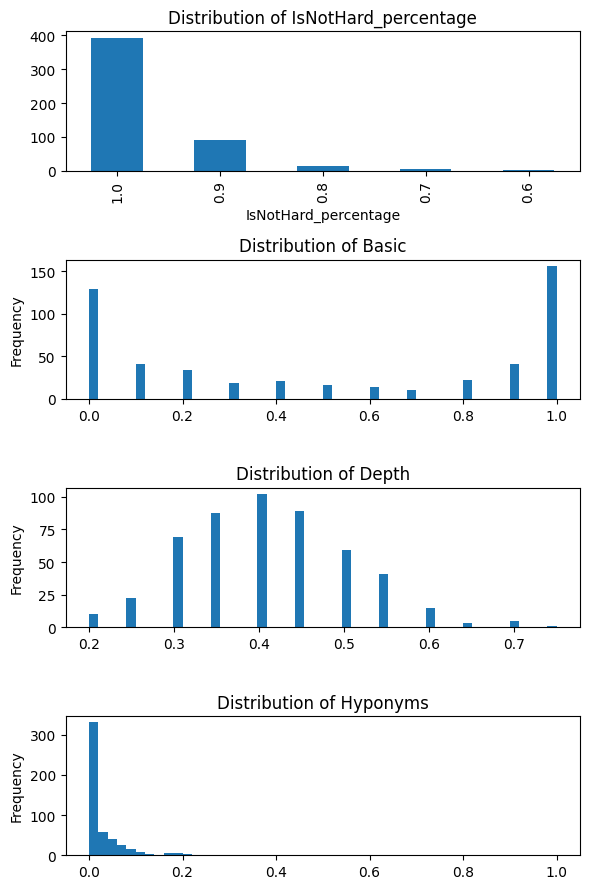

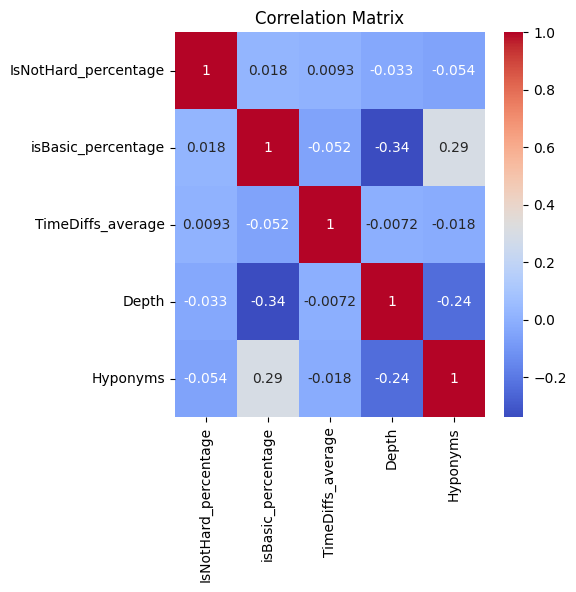

In [429]:
fig, ax = plt.subplots(4, 1, figsize=(6, 9))  # Half the size of the original

# 'is_hard' distribution
final_df['IsNotHard_percentage'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of IsNotHard_percentage')

# 'answer' distribution
final_df['isBasic_percentage'].plot(kind='hist', bins=50, ax=ax[1])
ax[1].set_title('Distribution of Basic')



# 'depth' distribution
final_df['Depth'].plot(kind='hist', bins=50, ax=ax[2])
ax[2].set_title('Distribution of Depth')

# 'hypernomin' distribution
final_df['Hyponyms'].plot(kind='hist', bins=50, ax=ax[3])
ax[3].set_title('Distribution of Hyponyms')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = final_df[['IsNotHard_percentage', 'isBasic_percentage', 'TimeDiffs_average','Depth','Hyponyms']].corr()

# Plot correlation matrix with a smaller size
plt.figure(figsize=(5,5))  # Specify the figure size
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Come da premesse, tramite la matrice di correlazione possiamo individuare:
- esistenza di un legame tra Numero di Iponimi e probabilità che un concetto sia Basic
- una correlazione negativa tra numero di Iponimi e aumento della Depth (quindi concetti piu specifici)
- una correlazione negativa tra Depth e probabilità che un concetto sia Basic

Per quanto riguarda il resto dei plot, posso dire che c'è un forte Bias verso l'etichettatura "Non è difficile"
il che indica che sarebbe meglio non utilizzarla come feature del modello, siccome causerebbe forte Bias. Il resto
delle feature segue invece una distribuzione normale ( con queesta rappresentazione non si nota, ma le parole Basic vs Advanced sono equamente distribuite)

Di seguito il plot (PCA) dei vari embedding. Purtroppo così visto è poco significativo, in realtà è costruito a partire dalle frasi degli esempi, definizioni e sinonimi associati ad un synset. Ho colorato diversamente i punti che identificano un concetto Basic da uno Advance e mi permetterei di dire che la vicinanza tra punti rossi e blu, potrebbe proprio rappresentare i legame tra i synset che è presente su Wordnet. ( Non ho fatto analisi in dettaglio però)

In [414]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Collect all embeddings in a list
embeddings_list = [emb for emb in final_df['Context Embedding']]

# If your embeddings are not already 1D, you can flatten them like this
embeddings_flattened = [emb.flatten() for emb in embeddings_list]

# Create a numpy array from the list
embeddings_array = np.array(embeddings_flattened)
import plotly.graph_objects as go
import numpy as np

# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings_array)

# Define color based on 'isBasic_percentage'
colors = ['red' if value > 0.5 else 'blue' for value in final_df['isBasic_percentage']]

# Define a trace
trace = go.Scatter3d(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    z=pca_result[:, 2],
    mode='markers',
    marker=dict(
        color=colors,
        size=5,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
    )
)

data = [trace]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


### Traning e Fit del modello: Logistic Regressor
Ho scelto di fare il fit su un regressore logistico in modo da poter utilizzare come feature anche quella Vettoriale relativa al Word Embedding (flattened).
Inoltre, siccome si tratta di un task di classificazione che coinvolge una variabile di output binaria come "Basic" e "Advanced" (non basic), allora il regressore logistico è un'opzione appropriata. Un altro pro è il fatto che sia computazionalmente efficiente.

In [447]:
final_df = pd.merge(df, merged_df, on='Synset', how='left')

In [448]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score


# Step 1: Prepare the data
X = final_df[["Depth", "TimeDiffs_average", "IsNotHard_percentage", "isBasic_percentage","Hyponyms"]]

# Encode the "Synset" column using Label Encoding
# Convert "Synset" column to numpy array
synset_array = final_df["Synset"].values
label_encoder = LabelEncoder()
X.loc[:,"Synset"] = label_encoder.fit_transform(synset_array)

# Ensure all embeddings are in the correct shape and stack them into a 2D array
embedding = np.stack(final_df['Context Embedding'].values)
embedding_flattened = embedding.reshape(embedding.shape[0], -1)
X = np.concatenate([X.values, embedding_flattened], axis=1)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = final_df["isBasic_percentage"]
y = y > 0.5  # Convert to binary labels

# Step 2: Handle missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)



# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Choose a classifier (Logistic Regression)
LR_model = LogisticRegression(max_iter=1000,penalty='l2')

# Step 5: Train the classifier
LR_model.fit(X_train, y_train)

# Step 6: Evaluate the classifier
y_pred = LR_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 7: Calculate additional evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Step 8: Print the additional evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", confusion)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", classification)


Accuracy: 0.8712871287128713
Precision: 0.8113207547169812
Recall: 0.9347826086956522
F1-score: 0.8686868686868686
Confusion Matrix:
 [[45 10]
 [ 3 43]]
ROC AUC: 0.8764822134387351
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.82      0.87        55
        True       0.81      0.93      0.87        46

    accuracy                           0.87       101
   macro avg       0.87      0.88      0.87       101
weighted avg       0.88      0.87      0.87       101



### Test sui risultati presi dal laboratorio 1 

Concept: door
1. give_up.v.11; score 0.1845, distance allow the other (baseball) team to score
2. unfold.v.04; score 0.1733, distance spread out or open from a closed or folded state
3. obstruct.v.02; score 0.1458, distance block passage through
4. use.v.03; score 0.1099, distance use up, consume fully
5. room.n.04; score 0.1048, distance the people who are present in a room

Concept: ladybug
1. insect.n.01; score 0.4524, distance small air-breathing arthropod
2. red.n.01; score 0.3113, distance red color or pigment; the chromatic color resembling the hue of blood
3. small.s.08; score 0.2880, distance have fine or very small constituent particles
4. coloring_material.n.01; score 0.1105, distance any material used for its color
5. point.n.09; score 0.0801, distance a very small circular shape

Concept: pain
1. discomfort.n.02; score 0.5286, distance an uncomfortable feeling of mental painfulness or distress
2. bad.s.03; score 0.4341, distance feeling physical discomfort or pain (`tough' is occasionally used colloquially for `bad')
3. emotional.a.03; score 0.3194, distance of or pertaining to emotion
4. forcible.s.01; score 0.2891, distance impelled by physical force especially against resistance
5. unpleasant.a.01; score 0.2552, distance disagreeable to the senses, to the mind, or feelings

Concept: blurriness
1. ocular.s.03; score 0.2576, distance visible; - Shakespeare
2. watch.v.03; score 0.2061, distance see or watch
3. visualize.v.01; score 0.2055, distance imagine; conceive of; see in one's mind
4. make.v.15; score 0.2024, distance make by shaping or bringing together constituents
5. perceive.v.02; score 0.1827, distance become conscious of




In [450]:
# Iterate through the dataset and calculate merged embeddings
MAX_WORDNET_HEIGHT = 20

data_to_fill = []
data = [
    {
        "Synset": 'room.n.04'
    },
    {
        "Synset": 'room.n.04'
    },
     {
        "Synset": 'ocular.s.03'
    },
    {
        "Synset": 'discomfort.n.02'
    },
    {
        "Synset": 'activeness.n.02'
    },
    {
        "Synset": 'writer.n.01'

    }
]
lab_1df=pd.read_json(json.dumps(data) )

for index, synset_row in lab_1df.iterrows():
    synset = wn.synset(synset_row['Synset'])
    depth = get_depth(synset)/MAX_WORDNET_HEIGHT
    n_hyponyms = get_hyponyms(synset)

    synonyms = get_synonyms(synset)
    definitions = get_definition(synset)
    examples = get_examples(synset)
    c = synonyms + [definitions] + examples 
    c = " ".join(c)
    emb = generate_context_embedding(c)  
    data_to_fill.append((synset.name(),depth,n_hyponyms,emb))

# Create a new DataFrame with merged embeddings

merged_df = pd.DataFrame(data_to_fill, columns=['Synset','Depth', 'Hyponyms', 'Context Embedding' ])
merged_df

,Synset,Depth,Hyponyms,Context Embedding
0,room.n.04,0.30,0,"[[0.019124668, -0.08168487, 0.48501053, -0.121..."
1,room.n.04,0.30,0,"[[0.019124668, -0.08168487, 0.48501053, -0.121..."
2,ocular.s.03,0.05,0,"[[-0.24286851, 0.19911972, 0.08576074, -0.2903..."
3,discomfort.n.02,0.40,0,"[[-0.36790997, 0.17742646, -0.34255153, -0.305..."
4,activeness.n.02,0.25,2,"[[0.08415472, -0.025137741, 0.105834104, -0.00..."
5,writer.n.01,0.45,35,"[[0.19014035, 0.12996915, 0.06072015, 0.148049..."


In [468]:
# Step 1: Prepare the data
Xtests_lab_wsd = merged_df[["Depth", "Hyponyms", "Synset"]]

# Encode the "Synset" column using Label Encoding
label_encoder = LabelEncoder()
Xtests_lab_wsd["Synset"] = label_encoder.fit_transform(merged_df["Synset"])

# Ensure all embeddings are in the correct shape and stack them into a 2D array
embedding_lab = np.stack(merged_df['Context Embedding'].values)
embedding_flattened_lab = embedding_lab.reshape(embedding_lab.shape[0], -1)

# Concatenate the input data with the flattened embedding
Xtests_lab_wsd = pd.concat([Xtests_lab_wsd, pd.DataFrame(embedding_flattened_lab)], axis=1)

# Convert column names to strings
Xtests_lab_wsd.columns = Xtests_lab_wsd.columns.astype(str)

# Step 2: Handle missing values
imputer = SimpleImputer(strategy="mean")
Xtests_lab_wsd = imputer.fit_transform(Xtests_lab_wsd)

# Convert Xtests_lab_wsd back to a DataFrame with column names
Xtests_lab_wsd = pd.DataFrame(Xtests_lab_wsd, columns=["Depth", "Hyponyms", "Synset"] + [f"embedding_{i+1}" for i in range(embedding_flattened_lab.shape[1])])

# Add the missing columns "TimeDiffs_average", "IsNotHard_percentage", "isBasic_percentage"
Xtests_lab_wsd["TimeDiffs_average"] = final_df["TimeDiffs_average"].mean()
Xtests_lab_wsd["IsNotHard_percentage"] = final_df["IsNotHard_percentage"].mean()
Xtests_lab_wsd["isBasic_percentage"] = final_df["isBasic_percentage"].mean()

print("Confidence score for each prediction:")

y_pred = LR_model.predict(Xtests_lab_wsd)
print(y_pred)

# Provide the confidence score for each prediction
confidence_scores = LR_model.predict_proba(Xtests_lab_wsd)

# Get the confidence of the predicted class
confidence_of_pred = np.max(confidence_scores, axis=1)
# print the confidence score for each prediction
for i in range(len(y_pred)):
    print(f"Prediction: {y_pred[i]}, Confidence: {confidence_of_pred[i]:.3f}")

Confidence score for each prediction:
[ True  True False False  True False]
Prediction: True, Confidence: 0.576
Prediction: True, Confidence: 0.576
Prediction: False, Confidence: 0.745
Prediction: False, Confidence: 0.979
Prediction: True, Confidence: 0.616
Prediction: False, Confidence: 0.997


### Risultati
Anche se ad un primo impatto sembrerebbe un'idea buona quella di affidarsi al concetto di profondità dell'albero di Wordnet per aggiungere informazione semantica legata alla Basicness / Advanceness di un concetto, in realtà dobbiamo ricordare i limiti di Wordnet ed in particolare il problema della sparsità:
- si riferisce al fatto che alcune parti dell'ontologia di WordNet possono avere una rappresentazione limitata o un numero relativamente basso di istanze specifiche rispetto ad altre parti dell'ontologia. In altre parole, ci possono essere alcune categorie o concetti che sono più densamente rappresentati e hanno un gran numero di istanze o sotto-categorie, mentre altre categorie possono essere meno rappresentate e avere un numero inferiore di istanze.

Nel caso specifico di "writer.n.01", anche se è un concetto specifico, il fatto che abbia 35 iponimi e una profondità di circa 10 (normalizzata è 0.45) indica che esistono diverse sottocategorie specifiche o istanze associate ad esso. Infatti, nonostante la combinazione "elevata altezza" + "elevati iponimi" dovrebbero farlo passare per un Outlier

